# Titanic survival with XGBoost

Full project on github:  
https://github.com/fdayde/kaggle-titanic

## Imports

In [1]:
import pandas as pd
import numpy as np
import os
import shap
import matplotlib.pyplot as plt
import missingno as msno
from IPython.display import display
from typing import Dict
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)

## Datasets 

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
DATASET_PATH = "/kaggle/input/titanic/"

test = pd.read_csv(os.path.join(DATASET_PATH, "test.csv"))
train = pd.read_csv(os.path.join(DATASET_PATH, "train.csv"))

datasets_dict = {
    "train": train,
    "test": test
}

test_memory = test.memory_usage(deep=True).sum()
train_memory = train.memory_usage(deep=True).sum()
print(f"Test dataset memory usage: {test_memory / (1024**2):.2f} MB")
print(f"Train dataset memory usage: {train_memory / (1024**2):.2f} MB")

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv
Test dataset memory usage: 0.14 MB
Train dataset memory usage: 0.31 MB


## Data Overview

In [3]:
class DataOverview:
    """
    A class to perform data overview and exploration on pandas DataFrames.
    """

    def __init__(self):
        """
        Initializes the DataOverview class.
        """
        pass  # No initialization parameters needed for now

    def data_overview(self, df: pd.DataFrame, df_name: str) -> None:
        """
        Display basic information about the DataFrame.

        Args:
            df (pd.DataFrame): The DataFrame to overview.
            df_name (str): The name of the DataFrame.
        """
        print(f"\n=== Data Overview: {df_name} ===")
        print(f"- Shape of the dataset: {df.shape}")
        print("- First five rows:")
        display(df.head())
        print("\n- Summary Statistics:")
        display(df.describe(include="all"))

    def missing_values_analysis(self, df: pd.DataFrame, df_name: str) -> None:
        """
        Analyze missing values in the DataFrame.

        Args:
            df (pd.DataFrame): The DataFrame to analyze.
            df_name (str): The name of the DataFrame.
        """
        print(f"\n=== Missing Values Analysis: {df_name} ===")
        missing = df.isnull().sum()
        missing = missing[missing > 0]
        print("- Missing values in each column:")
        print(missing)

        # Visualize missing values
        if missing.any():
            print("\n- Visualizing missing values:")
            msno.matrix(df)
            plt.show()
        else:
            print("No missing values found.")

    def duplicate_detection(self, df: pd.DataFrame, df_name: str) -> None:
        """
        Detect duplicate rows in the DataFrame.

        Args:
            df (pd.DataFrame): The DataFrame to check.
            df_name (str): The name of the DataFrame.
        """
        print(f"\n=== Duplicate Detection: {df_name} ===")
        duplicates = df[df.duplicated()]
        print(f"Number of duplicate rows: {duplicates.shape[0]}")
        if duplicates.shape[0] > 0:
            print("Duplicate rows:")
            display(duplicates)

    def print_data_types(self, df: pd.DataFrame, df_name: str) -> None:
        """
        Print data types and categorize features into numerical and categorical.

        Args:
            df (pd.DataFrame): The DataFrame to analyze.
            df_name (str): The name of the DataFrame.
        """
        print(f"\n=== Data Types: {df_name} ===")
        print(df.dtypes)

        print("\n => Numerical and categorical features based on types")
        numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
        categorical_features = df.select_dtypes(
            include=["object", "category"]
        ).columns.tolist()
        print("\nNumerical Features:", numerical_features)
        print("Categorical Features:", categorical_features)

    def data_exploration(self, df_dict: Dict[str, pd.DataFrame]) -> None:
        """
        Perform data exploration on a dictionary of DataFrames.

        Args:
            df_dict (Dict[str, pd.DataFrame]): Dictionary with DataFrame names as keys and DataFrames as values.
        """
        print("Starting data exploration on multiple DataFrames.")
        for df_name, df in df_dict.items():
            self.data_overview(df, df_name)
            self.missing_values_analysis(df, df_name)
            self.duplicate_detection(df, df_name)
            self.print_data_types(df, df_name)


Starting data exploration on multiple DataFrames.

=== Data Overview: train ===
- Shape of the dataset: (891, 12)
- First five rows:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



- Summary Statistics:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN



=== Missing Values Analysis: train ===
- Missing values in each column:
Age         177
Cabin       687
Embarked      2
dtype: int64

- Visualizing missing values:


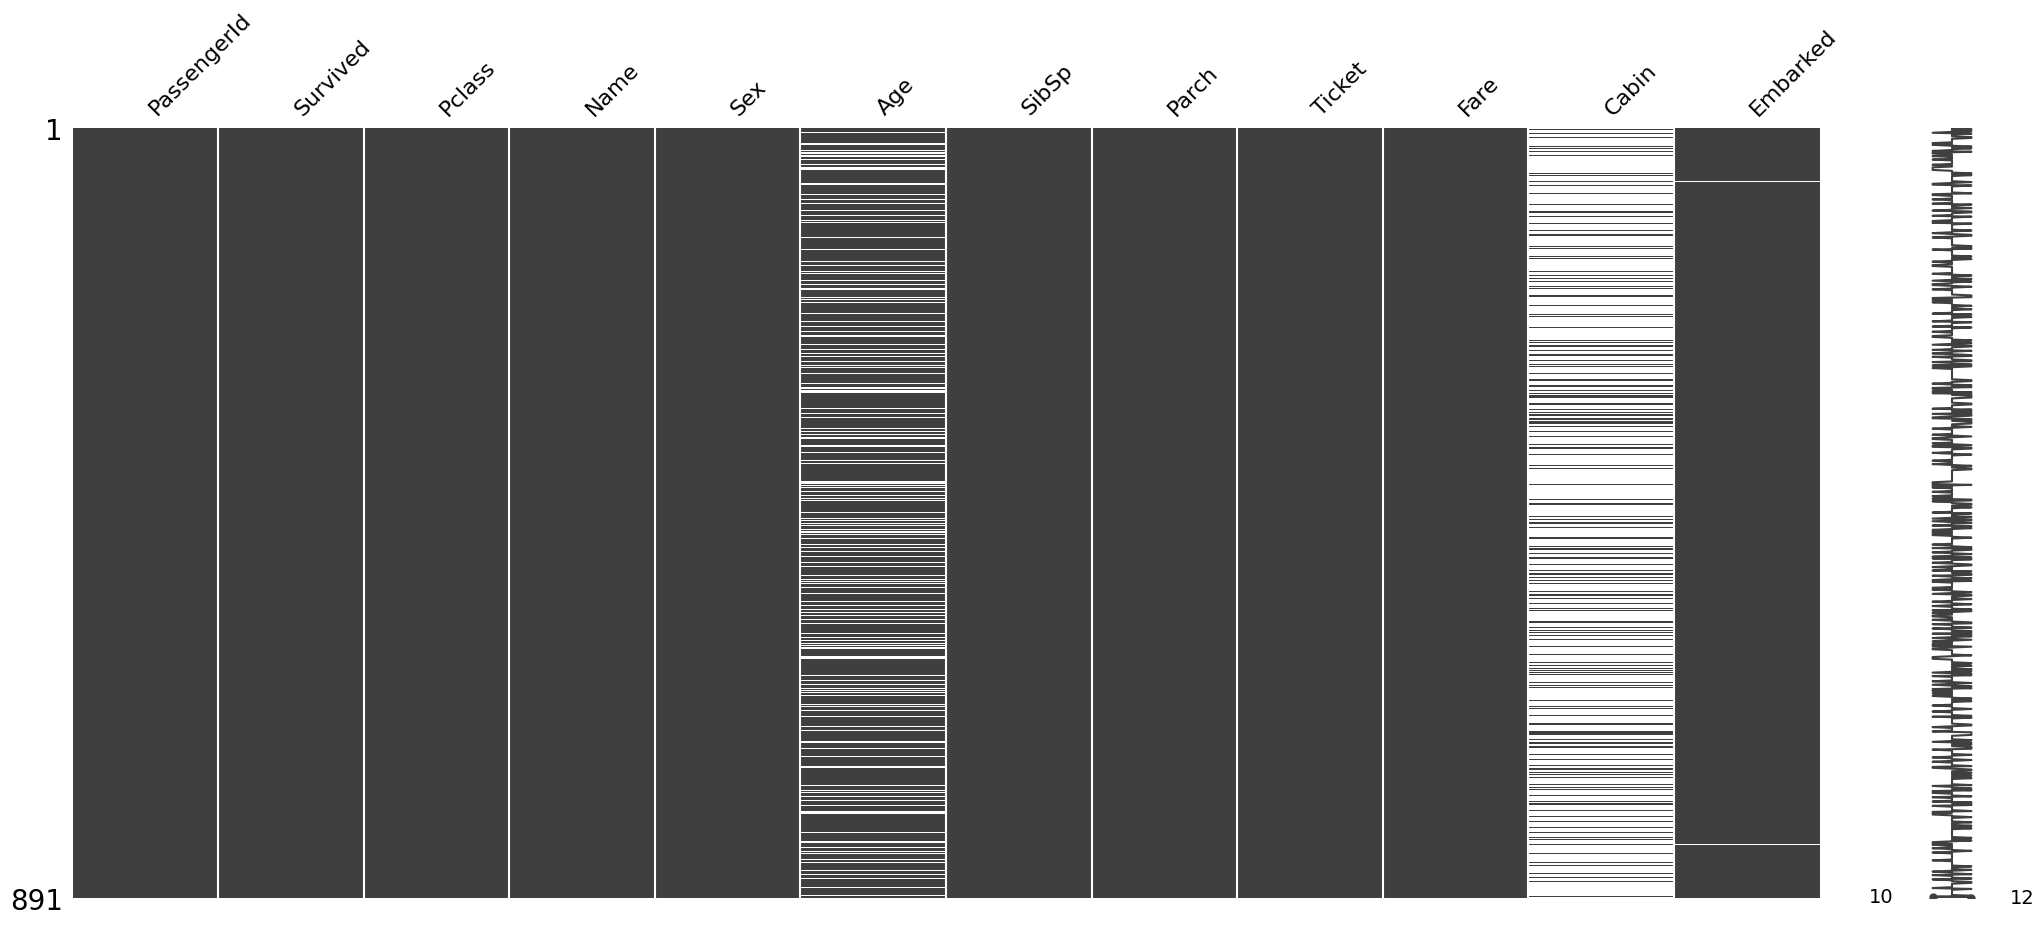


=== Duplicate Detection: train ===
Number of duplicate rows: 0

=== Data Types: train ===
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

 => Numerical and categorical features based on types

Numerical Features: ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical Features: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

=== Data Overview: test ===
- Shape of the dataset: (418, 11)
- First five rows:


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S



- Summary Statistics:


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Kelly, Mr. James",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN



=== Missing Values Analysis: test ===
- Missing values in each column:
Age       86
Fare       1
Cabin    327
dtype: int64

- Visualizing missing values:


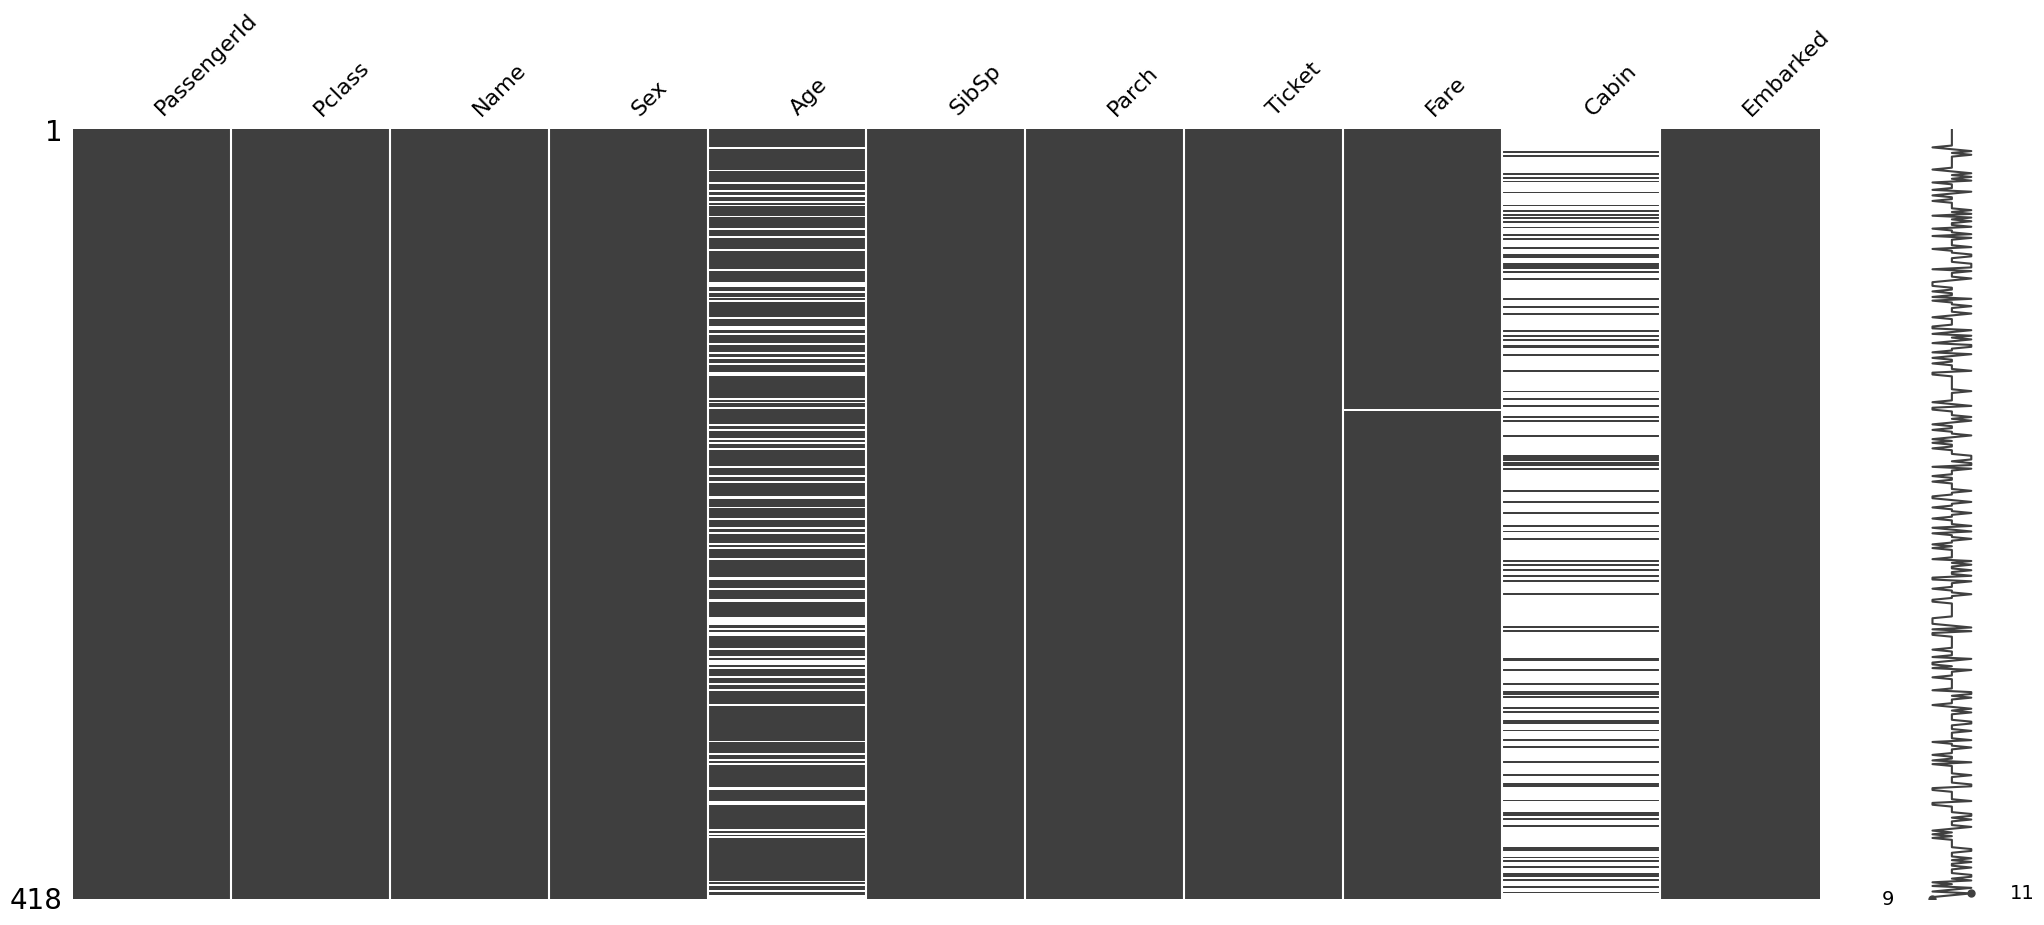


=== Duplicate Detection: test ===
Number of duplicate rows: 0

=== Data Types: test ===
PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

 => Numerical and categorical features based on types

Numerical Features: ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical Features: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


In [4]:
data_overview = DataOverview()
data_overview.data_exploration(datasets_dict)

## Data Management

Based on the data overview step, there are some data mangement step swe need to do such as : 
- type conversion,
- missing value management,
- extract relevant information from some features that seems too heterogeneous.

All the exploration is not show here, to keep the notebook short.

In [5]:
def type_conversion(df: pd.DataFrame, columns_to_convert: list):
    """
    Convert the type of specified columns from int to str.

    Parameters:
    - df: pd.DataFrame
        The DataFrame to process.
    - columns_to_convert: list
        A list of column names to convert from int to str.

    Returns:
    - df: pd.DataFrame
        The updated DataFrame.
    """
    for column in columns_to_convert:
        if column in df.columns:
            df[column] = df[column].astype(str)
        else:
            print(f"Warning: Column '{column}' not found in DataFrame.")

    return df


def get_data_types(df: pd.DataFrame, df_name: str = None, target_variable="Survived"):
    """
    Identify numerical and categorical features.
    Returns 2 lists: numerical_features and categorical_features,
    without the target in the categorical features list.

    Parameters:
    - df: pandas DataFrame
        The DataFrame to process.
    - df_name: str, optional
        The “name” of the DataFrame (e.g., 'train', 'test'). Defaults to None.
    - target_variable: str, default 'Survived'
        The name of the target variable (if present).

    Returns:
    - numerical_features: list
        List of numerical feature names.
    - categorical_features: list
        List of categorical feature names.
    """
    if target_variable in df.columns:
        target_in_df = True
    else:
        target_in_df = False

    numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df.select_dtypes(
        include=["object", "category"]
    ).columns.tolist()

    # Remove the target variable from numerical features if present
    if target_in_df and target_variable in numerical_features:
        numerical_features.remove(target_variable)

    # Print info about the target variable
    if target_in_df:
        print(f"Target Variable: {target_variable}")
    else:
        print(f"Target Variable '{target_variable}' not found in DataFrame {df_name}.")

    return numerical_features, categorical_features


def fare_missing_values_imputation(df_test: pd.DataFrame, df_train: pd.DataFrame):
    """
    Impute missing 'Fare' values in the test dataset based on median fares calculated from the test and train datasets combined.

    This function handles missing 'Fare' values by computing the median fare grouped by 'Pclass' and 'Embarked'
    from the combined dataset. It imputes missing 'Fare' values in the test dataset using these medians.
    If 'Embarked' is missing for a passenger, the function uses the median fare for the corresponding 'Pclass'.
    After imputation, it verifies that there are no remaining missing 'Fare' values in the test dataset.

    Parameters:
    - df_test (pd.DataFrame): The test DataFrame containing passenger data with potential missing 'Fare' values.
    - df_train (pd.DataFrame): The training DataFrame used to compute median fares.

    Returns:
    - pd.DataFrame: The test DataFrame with missing 'Fare' values imputed.
    """
    combined = pd.concat(
        [df_train.drop(columns=["Survived"], errors="ignore"), df_test], sort=False
    )

    # Compute median fare by 'Pclass' and 'Embarked'
    fare_median = combined.groupby(["Pclass", "Embarked"])["Fare"].median()
    fare_median_pclass = combined.groupby("Pclass")["Fare"].median()

    # Identify passenger(s) with missing 'Fare' in the test dataset
    missing_fare_indices = df_test[df_test["Fare"].isnull()].index

    # Impute missing 'Fare' values
    for idx in missing_fare_indices:
        pclass = df_test.loc[idx, "Pclass"]
        embarked = df_test.loc[idx, "Embarked"]

        if pd.isnull(embarked):
            # 'Embarked' is missing; use median fare for 'Pclass'
            imputed_fare = fare_median_pclass.loc[pclass]
        else:
            # 'Embarked' is not missing; use median fare for 'Pclass' and 'Embarked'
            imputed_fare = fare_median.loc[pclass, embarked]
            print(
                f"'Embarked' is {embarked} for passenger at index {idx}. Imputing 'Fare' with median fare {imputed_fare} for 'Pclass' {pclass} and 'Embarked' {embarked}."
            )

        # Impute the missing 'Fare'
        df_test.loc[idx, "Fare"] = imputed_fare

    # Verify that all missing 'Fare' values have been imputed
    print(
        "Remaining missing 'Fare' values in test dataset:",
        df_test["Fare"].isnull().sum(),
    )

    return df_test


def embarked_missing_value_imputation(df_train: pd.DataFrame):
    """
    Impute missing 'Embarked' value in the train dataset based on similar passengers according to Fare and Pclass on the combined train and test datasets.

    If 'Embarked' is missing for a passenger in the train dataset, the function repalces it with the value "C".
    After imputation, it verifies that there are no remaining missing 'Embarked' values in the test dataset.

    Parameters:
    - df_train (pd.DataFrame): The training DataFrame with a missing value for Embarked.

    Returns:
    - pd.DataFrame: The train DataFrame with the missing 'Emarked' value reaplced with "C".
    """
    df_train.loc[:, "Embarked"] = df_train["Embarked"].fillna("C")

    # Verify that all missing 'Embarked' values have been imputed
    print(
        "Remaining missing 'Embarked' values in train dataset:",
        df_train["Embarked"].isnull().sum(),
    )

    return df_train


def delete_features(var_list, var_to_delete):
    """
    Removes the features in 'var_to_delete' list from a list of fariables if they exist.

    Parameters:
    - var_list (list): A list of fariables.
    - var_to_delete (list): A list of features to remove from var_list.

    Returns:
    - list: var_list without the features in var_to_delete.
    """
    filtered_var_list = [
        feature for feature in var_list if feature not in var_to_delete
    ]
    # print("Features:", filtered_var_list)

    return filtered_var_list


def add_features(var_list, features_to_add):
    """
    Adds multiple features to a list of variables if they do not already exist.

    Parameters:
    - var_list (list): A list of variables.
    - features_to_add (list): A list of features to add to var_list.

    Returns:
    - list: var_list with the features_to_add included if they were not already present.
    """
    for feature in features_to_add:
        if feature not in var_list:
            var_list.append(feature)

    # print("Features:", var_list)

    return var_list


def extract_title_lastname(df):
    """Extracts 'Title' and 'Last_Name' from 'Name' column."""
    df["Last_Name"] = df["Name"].apply(lambda x: x.split(",")[0])
    df["Title"] = df["Name"].apply(lambda x: x.split(",")[1].split(".")[0].strip())
    return df


def manage_titles(df):
    """Manages 'Title' column by mapping it to a new 'Simplified_Title' column."""
    title_mapping = {
        "Master": "Child",
        "Miss": "Commoner",
        "Mrs": "Commoner",
        "Mr": "Commoner",
        "Dr": "Title",
        "Rev": "Title",
        "Sir": "Title",
        "Major": "Title",
        "Col": "Title",
        "Capt": "Title",
        "Don": "Title",
        "Jonkheer": "Title",
        "Lady": "Title",
        "Countess": "Title",
        "Other": "Commoner",
    }

    df["Simplified_Title"] = df["Title"].map(title_mapping)
    df.loc[:, "Simplified_Title"] = df["Simplified_Title"].fillna("Commoner")
    return df


def extract_deck(df):
    """Extract Deck from 'Cabin' column."""
    df["Deck"] = df["Cabin"].apply(lambda x: str(x)[0] if pd.notnull(x) else "Unknown")
    return df


def extract_family_alone(df):
    """Extracts 'Family_Size' and 'Is_Alone' from 'SibSp' and 'Parch' columns."""
    df["Family_Size"] = df["SibSp"] + df["Parch"] + 1
    df["Is_Alone"] = df["Family_Size"].apply(lambda x: 1 if x == 1 else 0)
    return df


def create_combined_dataset(train_df, test_df):
    """
    Create combined dataste from train and test without target variable
    """
    train_df["dataset_type"] = "train"
    test_df["dataset_type"] = "test"
    combined_df = pd.concat([train_df, test_df], sort=False)

    return combined_df


def replace_missing_age_with_median(combined_df):
    """
    Replace missing 'Age' values in the combined DataFrame with the median age
    of the corresponding group defined by 'Sex', 'Pclass', and 'Simplified_Title'.
    Then, separate the combined DataFrame back into train and test DataFrames.

    Parameters:
    - combined_df (pd.DataFrame): The combined DataFrame containing both train and test data,
                                with a 'dataset_type' column to distinguish between them.

    Returns:
    - tuple: A tuple containing two DataFrames:
           - train_data (pd.DataFrame): The train DataFrame with imputed 'Age' values and the original 'Survived' column.
           - test_data (pd.DataFrame): The test DataFrame with imputed 'Age' values.
    """
    combined_df["Age"] = combined_df["Age"].fillna(
        combined_df.groupby(["Sex", "Pclass", "Simplified_Title"])["Age"].transform(
            "median"
        )
    )

    train_data = combined_df[combined_df["dataset_type"] == "train"].drop(
        columns=["dataset_type"]
    )
    test_data = combined_df[combined_df["dataset_type"] == "test"].drop(
        columns=["dataset_type", "Survived"]
    )

    # Verify that all missing 'Age' values have been imputed
    print(
        "Remaining missing 'Age' values in the combined dataset:",
        combined_df["Age"].isnull().sum(),
    )
    return train_data, test_data


def create_log_fare(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds a new column 'LogFare' to the given DataFrame, containing the natural log of (Fare + 1).

    Args:
        df (pd.DataFrame):
            A pandas DataFrame that must include a 'Fare' column.

    Returns:
        pd.DataFrame:
            The same DataFrame with the added 'LogFare' column.

    Notes:
        - Using log(Fare + 1) helps stabilize variance when 'Fare' is heavily skewed.
        - This function modifies the input DataFrame in-place.
        - If 'Fare' contains negative or missing values, the result in 'LogFare' could be NaN or raise errors.
    """
    df["LogFare"] = np.log1p(df["Fare"])
    return df


def add_age_group(df: pd.DataFrame, age_column: str = "Age") -> pd.DataFrame:
    """
    Adds an 'AgeGroup' column to the given DataFrame, categorizing ages into predefined groups.

    Args:
        df (pd.DataFrame): The input DataFrame containing the age data.
        age_column (str): The name of the column containing age values. Default is 'Age'.

    Returns:
        pd.DataFrame: The modified DataFrame with a new 'AgeGroup' column.

    Notes:
        - Age groups are defined as follows:
            - 'Child': 0–11
            - 'Teenager': 12–19
            - 'Adult_20_39': 20–39
            - 'Adult_40_59': 40–59
            - '60+': 60 and above
        - Non-numeric or missing values in the age column will result in NaN in the 'AgeGroup' column.
    """
    # Define age group bins and labels
    bins = [0, 12, 20, 40, 60, float("inf")]
    labels = ["Child", "Teenager", "Adult_20_39", "Adult_40_59", "60+"]

    # Use pd.cut to create the AgeGroup column
    df["AgeGroup"] = pd.cut(df[age_column], bins=bins, labels=labels, right=False)

    return df


def run_dm_pipeline(test, train):
    """
    Run a data management pipeline with feature engineering steps for the Titanic dataset.

    This function applies a series of transformations to both the train and test datasets,
    including data type conversions, missing value imputation, feature extraction, and
    dropping unnecessary columns. The goal is to prepare the data for downstream modeling.

    Args:
        test (pd.DataFrame): The test dataset, expected to contain columns such as 'Pclass', 'SibSp',
            'Parch', 'Fare', 'Cabin', and other Titanic-related features.
        train (pd.DataFrame): The training dataset, expected to contain the same columns as `test` plus
            the target variable 'Survived'.

    Returns:
        dict:
            A dictionary with the following keys:
            - "test" (pd.DataFrame): The processed test dataset.
            - "train" (pd.DataFrame): The processed train dataset.
            - "categorical_features" (list of str): The final list of categorical feature names.
            - "numerical_features" (list of str): The final list of numerical feature names.
            - "target" (str): The target column name ('Survived').

    Processing Steps Overview:
        1. Type conversion of specified columns (e.g., 'Pclass') in both datasets.
        2. Identification of numerical and categorical features.
        3. Imputation of missing 'Fare' values in the test set using information from the train set.
        4. Handling of missing 'Embarked' values in the train set.
        5. Extraction of 'Title' and 'LastName' from passenger names.
        6. Creation of simplified or grouped titles via 'manage_titles'.
        7. Feature engineering for 'Deck' based on cabin information.
        8. Removal of unused columns (e.g., 'Name', 'LastName', 'Title', 'Cabin', 'Ticket').
        9. Extraction of family-related features (e.g., 'Is_Alone', 'Family_Size').
        10. Final data type conversions and cleanup.
        11. Replacement of missing 'Age' values with median ages per group.
        12. Add column 'LogFare' to the datasets.
        13. Add column 'AgeGroup' to the datasets.

    Note:
        - This pipeline modifies the input DataFrames in place and returns the final versions.
        - It is tailored specifically to the Titanic dataset but can serve as a template for
          other datasets with similar preprocessing needs.
    """
    train = type_conversion(df=train, columns_to_convert=["Pclass"])
    test = type_conversion(df=test, columns_to_convert=["Pclass"])

    numerical_features_train, categorical_features_train = get_data_types(
        train, df_name="train", target_variable="Survived"
    )
    numerical_features_test, categorical_features_test = get_data_types(
        test, df_name="test", target_variable="Survived"
    )

    test = fare_missing_values_imputation(df_test=test, df_train=train)

    combined = create_combined_dataset(train_df=train, test_df=test)
    train = embarked_missing_value_imputation(train)

    train = extract_title_lastname(train)
    test = extract_title_lastname(test)

    train = manage_titles(train)
    test = manage_titles(test)

    categorical_features_train = add_features(
        var_list=categorical_features_train, features_to_add=["Simplified_Title"]
    )
    categorical_features_test = add_features(
        var_list=categorical_features_test, features_to_add=["Simplified_Title"]
    )

    test = extract_deck(test)
    train = extract_deck(train)

    categorical_features_train = add_features(
        var_list=categorical_features_train, features_to_add=["Deck"]
    )
    categorical_features_test = add_features(
        var_list=categorical_features_test, features_to_add=["Deck"]
    )

    to_delete = ["Name", "LastName", "Title", "Cabin", "Ticket"]
    categorical_features_train = delete_features(
        var_list=categorical_features_train, var_to_delete=to_delete
    )
    categorical_features_test = delete_features(
        var_list=categorical_features_test, var_to_delete=to_delete
    )

    test = extract_family_alone(test)
    train = extract_family_alone(train)

    train = type_conversion(df=train, columns_to_convert=["Is_Alone"])
    test = type_conversion(df=test, columns_to_convert=["Is_Alone"])

    numerical_features_train = add_features(
        var_list=numerical_features_train, features_to_add=["Family_Size"]
    )
    numerical_features_test = add_features(
        var_list=numerical_features_test, features_to_add=["Family_Size"]
    )

    categorical_features_train = add_features(
        var_list=categorical_features_train, features_to_add=["Is_Alone"]
    )
    categorical_features_test = add_features(
        var_list=categorical_features_test, features_to_add=["Is_Alone"]
    )

    to_delete = ["SibSp", "Parch"]
    numerical_features_train = delete_features(
        var_list=numerical_features_train, var_to_delete=to_delete
    )
    numerical_features_test = delete_features(
        var_list=numerical_features_test, var_to_delete=to_delete
    )

    combined = create_combined_dataset(train_df=train, test_df=test)
    train, test = replace_missing_age_with_median(combined_df=combined)

    train = create_log_fare(train)
    test = create_log_fare(test)
    numerical_features_train = add_features(
        var_list=numerical_features_train, features_to_add=["LogFare"]
    )
    numerical_features_test = add_features(
        var_list=numerical_features_test, features_to_add=["LogFare"]
    )
    numerical_features_train = delete_features(
        var_list=numerical_features_train, var_to_delete=["Fare"]
    )
    numerical_features_test = delete_features(
        var_list=numerical_features_test, var_to_delete=["Fare"]
    )

    train = add_age_group(train)
    test = add_age_group(test)
    categorical_features_train = add_features(
        var_list=categorical_features_train, features_to_add=["AgeGroup"]
    )
    categorical_features_test = add_features(
        var_list=categorical_features_test, features_to_add=["AgeGroup"]
    )
    numerical_features_train = delete_features(
        var_list=numerical_features_train, var_to_delete=["Age"]
    )
    numerical_features_test = delete_features(
        var_list=numerical_features_test, var_to_delete=["Age"]
    )

    numerical_features_train.remove("PassengerId")

    categorical_features = categorical_features_train
    numerical_features = numerical_features_train
    target = "Survived"

    test_ids = test["PassengerId"].copy()

    print("\nCategorical_features:", categorical_features)
    print("Numerical features:", numerical_features)
    print("target:", target)

    return {
        "test": test,
        "train": train,
        "categorical_features": categorical_features,
        "numerical_features": numerical_features,
        "target": target,
        "test_ids": test_ids
    }


In [6]:
result = run_dm_pipeline(test, train)

categorical_features = result["categorical_features"]
numerical_features = result["numerical_features"]
target = result["target"]
test_ids = result["test_ids"]

Target Variable: Survived
Target Variable 'Survived' not found in DataFrame test.
'Embarked' is S for passenger at index 152. Imputing 'Fare' with median fare 8.05 for 'Pclass' 3 and 'Embarked' S.
Remaining missing 'Fare' values in test dataset: 0
Remaining missing 'Embarked' values in train dataset: 0
Remaining missing 'Age' values in the combined dataset: 0

Categorical_features: ['Pclass', 'Sex', 'Embarked', 'Simplified_Title', 'Deck', 'Is_Alone', 'AgeGroup']
Numerical features: ['Family_Size', 'LogFare']
target: Survived


## XGBoost
After Data analysis steps and model selection between Logistic Regression, KNN, Random Forest, XGBoost showed the best performances.

In [7]:
def create_preprocessor(numeric_features, categorical_features):
    """
    Create a ColumnTransformer that processes numeric and 
    categorical features for the Titanic dataset.

    Args:
        numeric_features (list): List of numeric column names.
        categorical_features (list): List of categorical column names.

    Returns:
        ColumnTransformer: A scikit-learn ColumnTransformer pipeline.
    """

    # Pipeline for numeric features
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    # Pipeline for categorical features using OneHotEncoder:
    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
    ])

    # Combine numeric and categorical pipelines
    preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])

    return preprocessor

In [8]:
def create_xgboost_pipeline(
    numeric_features,
    categorical_features,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
):
    """
    Create a pipeline for XGBoost on the Titanic dataset.

    Args:
        numeric_features (list): Numeric column names.
        categorical_features (list): Categorical column names.
        n_estimators (int): Number of gradient boosted trees.
        learning_rate (float): Boosting learning rate.
        max_depth (int): Maximum tree depth for base learners.
        random_state (int): Random seed.

    Returns:
        Pipeline: A scikit-learn Pipeline object.
    """
    preprocessor = create_preprocessor(numeric_features, categorical_features)

    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            use_label_encoder=False,
            eval_metric="logloss",
            random_state=random_state
        ))
    ])

    return pipeline

### Test-Train split

In [9]:
test_df = result["test"][categorical_features + numerical_features]
train_df = result["train"][categorical_features + numerical_features + [target]]

X = train_df[numerical_features + categorical_features]
y = train_df[target]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### XGBoost pipeline

In [10]:
xgb_pipeline = create_xgboost_pipeline(
    numeric_features=numerical_features,
    categorical_features=categorical_features,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

In [11]:
xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Family_Size', 'LogFare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex', 'Emba...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [12]:
xgb_preds = xgb_pipeline.predict(X_valid)
print("XGBoost accuracy:", accuracy_score(y_valid, xgb_preds))

XGBoost accuracy: 0.8100558659217877


In [13]:
xgb_probs = xgb_pipeline.predict_proba(X_valid)[:, 1]

In [14]:
def evaluate_model(name, y_true, y_pred, y_proba=None):
    print(f"--- {name} ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    if y_proba is not None:
        print("ROC AUC Score:", roc_auc_score(y_true, y_proba))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print()

In [15]:
evaluate_model("XGBoost", y_valid, xgb_preds, y_proba=xgb_probs)

--- XGBoost ---
Accuracy: 0.8100558659217877
Precision: 0.7777777777777778
Recall: 0.7567567567567568
F1 Score: 0.7671232876712328
ROC AUC Score: 0.8902187902187901
Confusion Matrix:
 [[89 16]
 [18 56]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.85      0.84       105
         1.0       0.78      0.76      0.77        74

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179




### Hyperparameter tuning

In [16]:
param_grid = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [3, 5, 7],
    "classifier__learning_rate": [0.01, 0.1, 0.2],
    "classifier__subsample": [0.8, 1.0],
    "classifier__colsample_bytree": [0.8, 1.0]
}

In [17]:
grid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    scoring="accuracy",   # or "f1", "precision", etc.
    cv=5,                 # 5-fold cross-validation
    n_jobs=-1,            # Use all CPU cores
    verbose=1             # Print progress
)

In [18]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categ

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Family_Size',
                                                                          'LogFare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignor...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=200,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'classifier__colsample_bytree': [0.8, 1.0],
                         'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__max_depth': [3, 5, 7],
                         'classifier__n_estimators': [100, 200, 300],
                         'classifier__subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [19]:
print("Best CV score:", grid_search.best_score_)
print("Best params:", grid_search.best_params_)

Best CV score: 0.8398699891657639
Best params: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 300, 'classifier__subsample': 1.0}


In [20]:
best_xgb_pipeline = grid_search.best_estimator_

### Evaluation on the validation set

In [21]:
y_valid_pred = best_xgb_pipeline.predict(X_valid)

accuracy = accuracy_score(y_valid, y_valid_pred)
precision = precision_score(y_valid, y_valid_pred)
recall = recall_score(y_valid, y_valid_pred)
f1 = f1_score(y_valid, y_valid_pred)

print("Validation set metrics:")
print("Accuracy: ", accuracy)
print("Precision:", precision)
print("Recall:   ", recall)
print("F1 Score: ", f1)
print("\nDetailed Classification Report:\n", classification_report(y_valid, y_valid_pred))


Validation set metrics:
Accuracy:  0.8156424581005587
Precision: 0.8153846153846154
Recall:    0.7162162162162162
F1 Score:  0.762589928057554

Detailed Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.89      0.85       105
         1.0       0.82      0.72      0.76        74

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179



### Interpretability

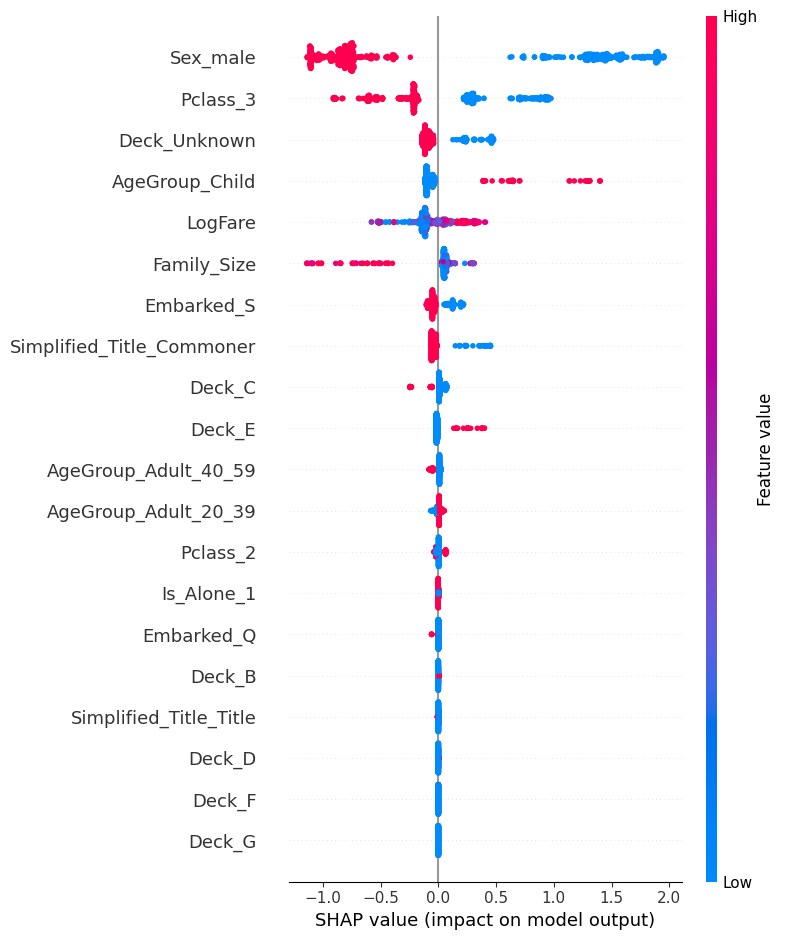

In [22]:
# Separate the trained pipeline steps: preprocessor vs. classifier
best_pipeline = grid_search.best_estimator_
preprocessor = best_pipeline["preprocessor"]
xgb_model = best_pipeline["classifier"]  # This is the XGBClassifier

# Transform the training data using the preprocessor
#    so we get the exact numeric matrix that XGBClassifier sees.
X_train_transformed = preprocessor.transform(X_train)

# Create a SHAP Explainer for XGBoost
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train_transformed)

# Add features names: 
cat_ohe = preprocessor.named_transformers_["cat"]["onehot"]  
cat_feature_names = cat_ohe.get_feature_names_out(input_features=categorical_features)
# numeric_features remains the same, except for any dropped columns, so it’s straightforward:
num_feature_names = numerical_features
# Combine them (ColumnTransformer order is [num, cat])
all_transformed_feature_names = list(num_feature_names) + list(cat_feature_names)

shap.summary_plot(shap_values, X_train_transformed, feature_names=all_transformed_feature_names)

## Submission

In [23]:
X_test = test_df[numerical_features + categorical_features]
test_preds = best_xgb_pipeline.predict(X_test)

In [24]:
submission = pd.DataFrame({"PassengerId": test_ids, "Survived": test_preds})
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


In [25]:
submission.to_csv("submission.csv", index=False)